## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.


In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import time

/Users/anton/miniconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


# 1. Подготовка

In [2]:
frame = pd.read_csv("taxi.csv",parse_dates =[0],index_col= 0)

In [3]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
frame = frame.sort_index()

Убедимся, что все прошло корректно

In [5]:
frame.index.is_monotonic

True

In [6]:
frame.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


заметим, что у нас данные с переодичностью 10 минут, ресемплируем их

In [7]:
frame = frame.resample("1H").sum()

создадим переменную, для сравнения какая выборка(исходная или полученная путем разности рядов) более стационарная, а так же переменную для создания корректных признаков признаков 

In [8]:
frame_new = frame.copy()
final_frame = frame.copy()

In [9]:
frame["rolling_mean"] = frame["num_orders"].rolling(20).mean()
frame["rolling_std"] = frame["num_orders"].rolling(20).std()

Вывод: Данные подготовлины к анализу

# 2. Анализ

Посмотрим на данные при помощи графиков 

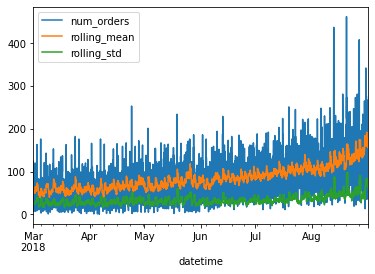

In [10]:
frame.plot()

Изначально выборка достаточно стационарна, посмотрим ли сильно измениться ситуация, если получить разность ряда

In [11]:
frame_new = frame - frame.shift()


In [12]:
frame_new["rolling_mean"] = frame_new["num_orders"].rolling(20).mean()
frame_new["rolling_std"] = frame_new["num_orders"].rolling(20).std()

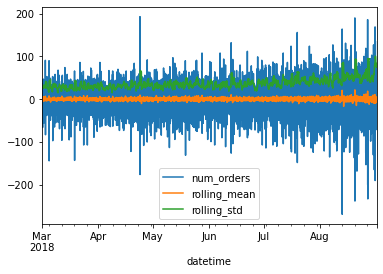

In [13]:
frame_new.plot()

In [14]:

from statsmodels.tsa.stattools import adfuller

ts = final_frame['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


In [15]:
frame_new.describe()

,num_orders,rolling_mean,rolling_std
count,4415.000000,4396.000000,4396.000000
mean,0.018347,0.024488,37.989795
std,39.023437,2.801253,12.318616
min,-269.000000,-16.650000,14.839049
25%,-22.000000,-1.750000,29.647457
50%,1.000000,-0.050000,35.859650
75%,23.000000,1.650000,43.480720
max,193.000000,21.800000,100.717675


Удалим все признаки, которые использовались для анализа и создадим новые, которые не будут получание на истинном целевом признаке

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(final_frame,24,20)

графики тренда и сезонности

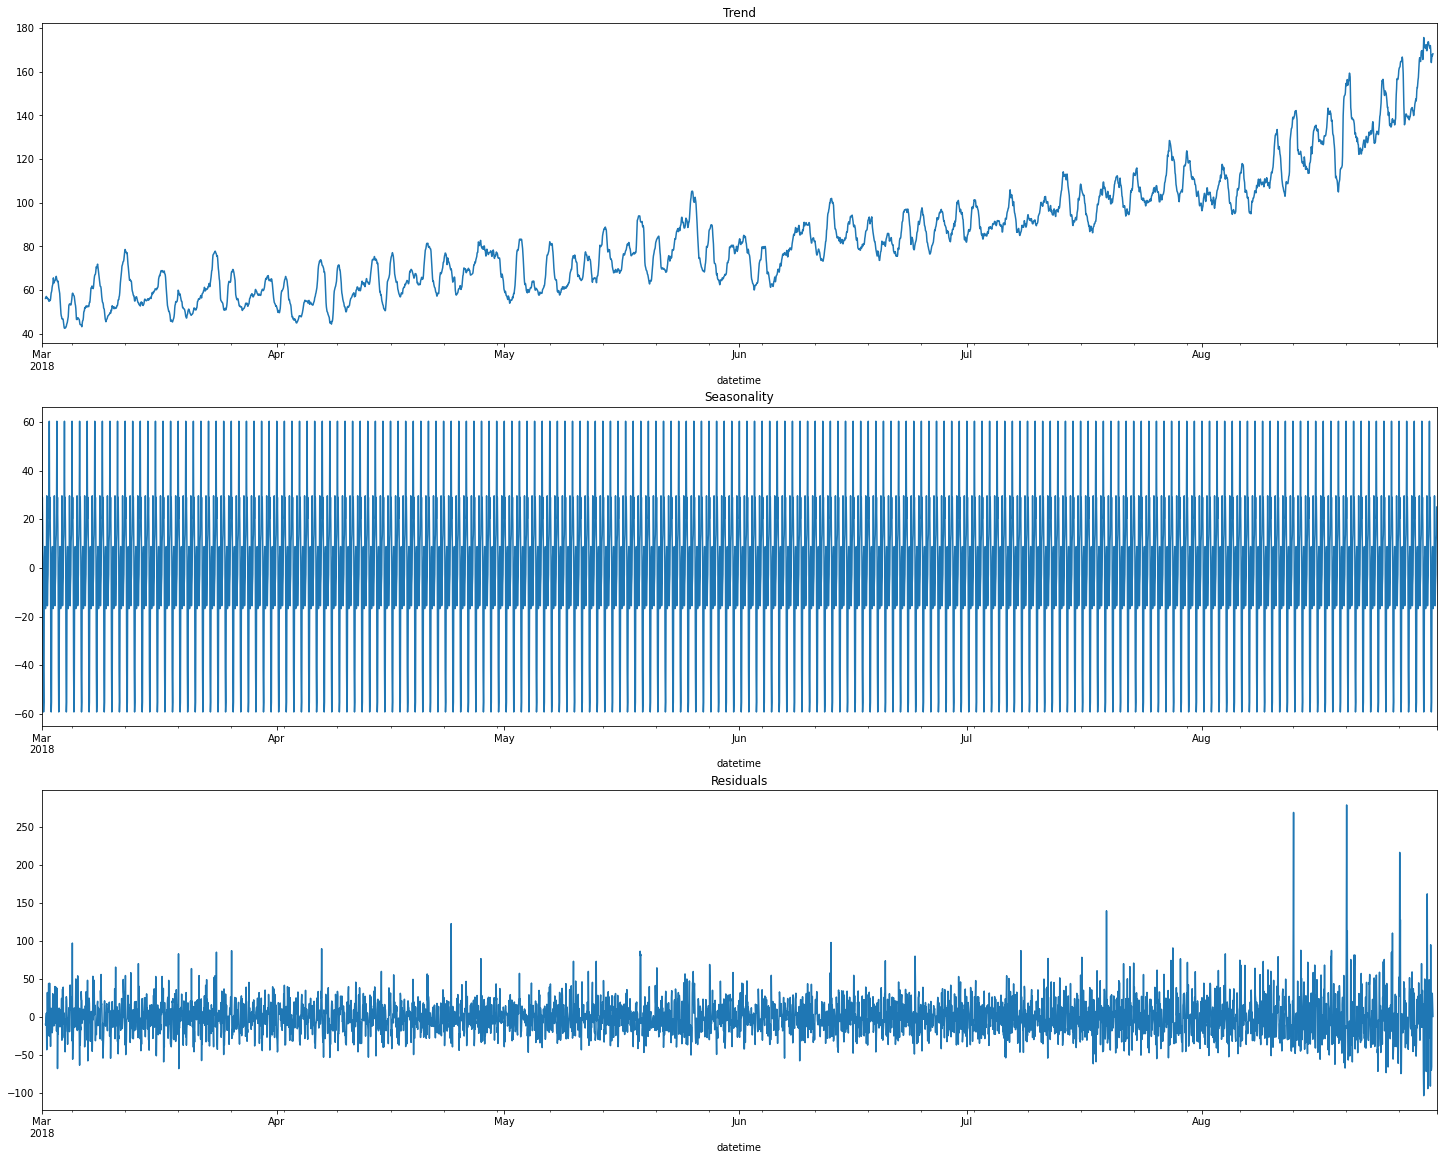

In [18]:
decomposed = seasonal_decompose(final_frame["num_orders"])
fig,ax = plt.subplots(3,1,figsize = (25,20))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

так же рассмотрим сезонность на небольшом времнном промежутке

Text(0.5, 1.0, 'Seasonality четвертая неделя апреля')

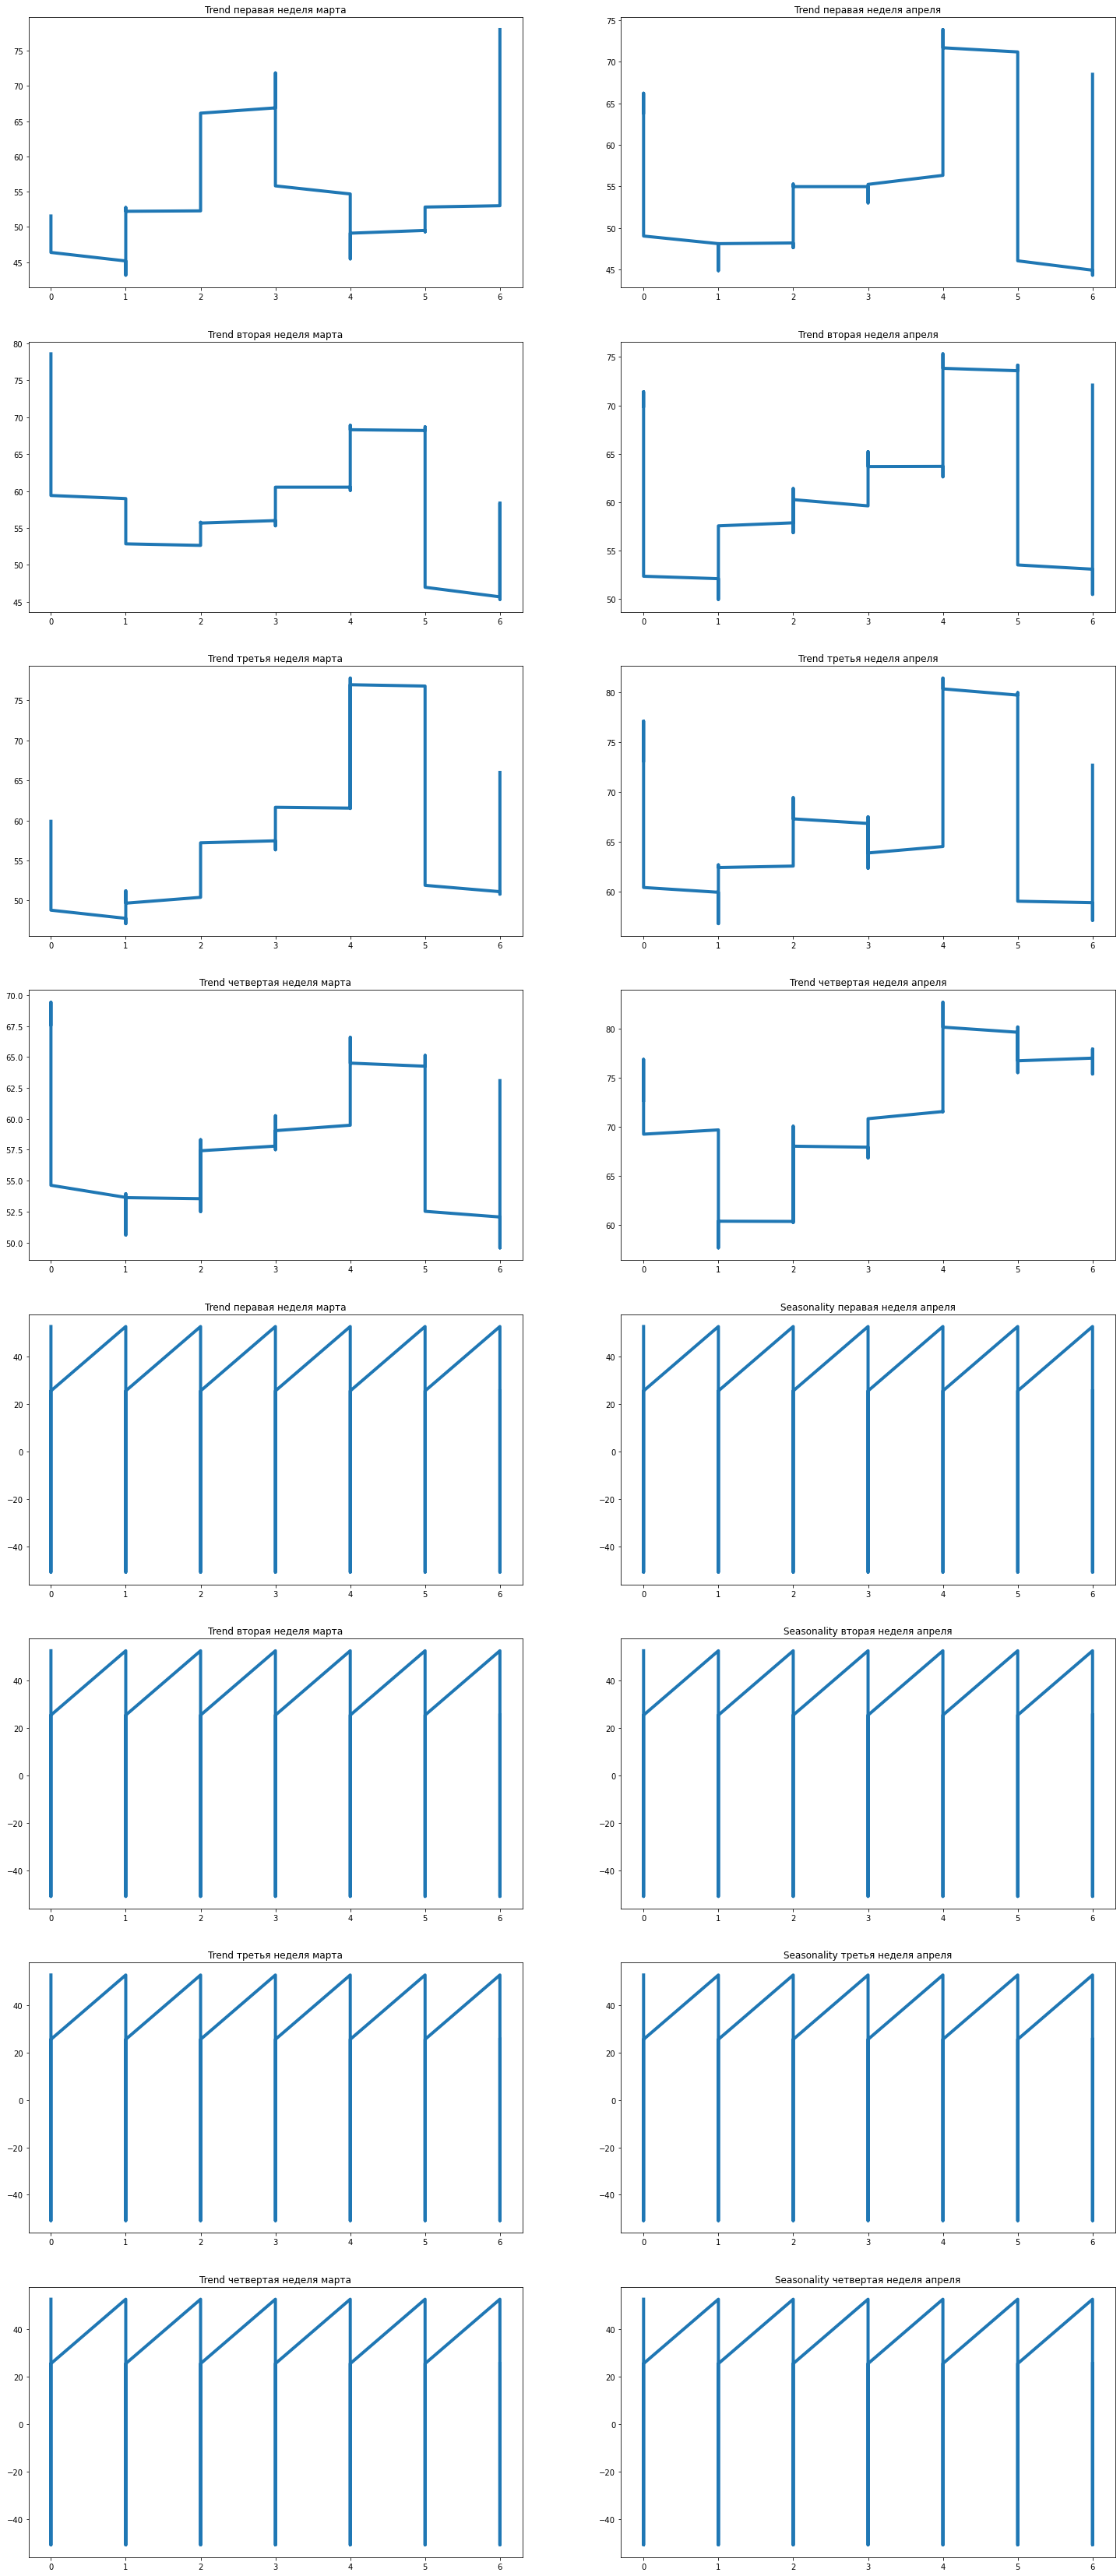

In [19]:
decomposed_short = seasonal_decompose(final_frame["2018-03-05":"2018-04-29"]["num_orders"])
fig2,ax2 = plt.subplots(8,2,figsize = (25,60))
# Trend
    # Март
ax2[0][0].plot(decomposed_short.trend["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.trend["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[0][0].set_title("Trend перавая неделя марта")

ax2[1][0].plot(decomposed_short.trend["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.trend["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[1][0].set_title("Trend вторая неделя марта")

ax2[2][0].plot(decomposed_short.trend["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.trend["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[2][0].set_title("Trend третья неделя марта")

ax2[3][0].plot(decomposed_short.trend["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.trend["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[3][0].set_title("Trend четвертая неделя марта")

    # Апрель
ax2[0][1].plot(decomposed_short.trend["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.trend["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[0][1].set_title("Trend перавая неделя апреля")

ax2[1][1].plot(decomposed_short.trend["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.trend["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[1][1].set_title("Trend вторая неделя апреля")

ax2[2][1].plot(decomposed_short.trend["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.trend["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[2][1].set_title("Trend третья неделя апреля")

ax2[3][1].plot(decomposed_short.trend["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.trend["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[3][1].set_title("Trend четвертая неделя апреля")
# Seasonality
    # Март
ax2[4][0].plot(decomposed_short.seasonal["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.seasonal["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[4][0].set_title("Trend перавая неделя марта")

ax2[5][0].plot(decomposed_short.seasonal["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.seasonal["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[5][0].set_title("Trend вторая неделя марта")

ax2[6][0].plot(decomposed_short.seasonal["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.seasonal["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[6][0].set_title("Trend третья неделя марта")

ax2[7][0].plot(decomposed_short.seasonal["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.seasonal["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[7][0].set_title("Trend четвертая неделя марта")

    # Апрель
ax2[4][1].plot(decomposed_short.seasonal["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.seasonal["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[4][1].set_title("Seasonality перавая неделя апреля")

ax2[5][1].plot(decomposed_short.seasonal["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.seasonal["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[5][1].set_title("Seasonality вторая неделя апреля")

ax2[6][1].plot(decomposed_short.seasonal["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.seasonal["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[6][1].set_title("Seasonality третья неделя апреля")

ax2[7][1].plot(decomposed_short.seasonal["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.seasonal["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[7][1].set_title("Seasonality четвертая неделя апреля")




1 марта 2018 это четверг, поэтому при рассмотрении недель, лучше будет взять даты с понедельника по воскресение, то есть с 5 марта по 29 апреля. Рассмотрим их на осях количество заказов и день недели, а не количество заказов и число месяца. Здесь мы можем увидеть,сезонность остается неизменной на протяжении всего исследуемого периода, в начале каждого дня у нас пик, потом резкое падение, затем в течение дня количество заказов растет и к концу дня достигает нового пика. Можно заметить тренд на рост числа заказов в понедльник, тренд на падение заказов во вторник, который со 2 недели апреля меняется на рост. А так же тренд на рост заказов во второй половине недели

In [20]:
train,test = train_test_split(final_frame,shuffle = False, random_state = 42, test_size = 0.1)
valid,test = train_test_split(test,shuffle = False, random_state = 42, test_size = 0.5)

In [21]:
train = train.dropna()

In [22]:
(train_features,
valid_features,
test_features) = (train.drop('num_orders',axis = 1),
                  valid.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(train_target,
valid_target,
test_target) = (train['num_orders'],
                valid['num_orders'],
                test['num_orders'])

Вывод: 
- данные проанализированны 
- признаки созданны
- подготовка к обучению завершена

# 3. Обучение

In [23]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)
# RandomForest
RF = RandomForestRegressor(random_state=42)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RF_grid = GridSearchCV(RF,parametrs,cv = splits,verbose=True,n_jobs=-1)
RF_grid.fit(train_features,train_target)

# CatBoost
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 42)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(train_features,train_target),cv=splits,verbose=True)




Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    3.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.2s finished



bestTest = 33.49483561
bestIteration = 428

0:	loss: 33.4948356	best: 33.4948356 (0)	total: 1.48s	remaining: 13.3s

bestTest = 33.36755682
bestIteration = 93

1:	loss: 33.3675568	best: 33.3675568 (1)	total: 2.91s	remaining: 11.7s

bestTest = 36.45874504
bestIteration = 47

2:	loss: 36.4587450	best: 33.3675568 (1)	total: 4.57s	remaining: 10.7s

bestTest = 33.64987815
bestIteration = 31

3:	loss: 33.6498782	best: 33.3675568 (1)	total: 5.93s	remaining: 8.89s

bestTest = 36.23381101
bestIteration = 18

4:	loss: 36.2338110	best: 33.3675568 (1)	total: 7.57s	remaining: 7.57s

bestTest = 37.2044947
bestIteration = 560

5:	loss: 37.2044947	best: 33.3675568 (1)	total: 39.1s	remaining: 26.1s

bestTest = 38.72025445
bestIteration = 172

6:	loss: 38.7202545	best: 33.3675568 (1)	total: 1m 10s	remaining: 30.2s

bestTest = 38.61688947
bestIteration = 50

7:	loss: 38.6168895	best: 33.3675568 (1)	total: 1m 42s	remaining: 25.5s

bestTest = 39.90582347
bestIteration = 30

8:	loss: 39.9058235	best: 33.367

In [24]:
%%time
# LightGBM
lgb_train = lgb.Dataset(train_features,train_target)
lgb_valid = lgb.Dataset(valid_features,valid_target, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_valid],
                verbose_eval=100)

[100]	training's l2: 161.108	valid_1's l2: 1484.69
[200]	training's l2: 71.9449	valid_1's l2: 1469.13
[300]	training's l2: 34.3034	valid_1's l2: 1442.35
[400]	training's l2: 16.9175	valid_1's l2: 1437.02
[500]	training's l2: 8.49085	valid_1's l2: 1436.2
[600]	training's l2: 4.53091	valid_1's l2: 1434.71
[700]	training's l2: 2.37252	valid_1's l2: 1434.6
[800]	training's l2: 1.33232	valid_1's l2: 1436.13
[900]	training's l2: 0.694547	valid_1's l2: 1436.1
[1000]	training's l2: 0.370973	valid_1's l2: 1437.25
CPU times: user 15.2 s, sys: 513 ms, total: 15.7 s
Wall time: 1.44 s


In [25]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 33.8780260	total: 4.63ms	remaining: 4.62s
100:	learn: 16.4980834	total: 240ms	remaining: 2.14s
200:	learn: 12.5952026	total: 374ms	remaining: 1.49s
300:	learn: 9.9804398	total: 514ms	remaining: 1.19s
400:	learn: 8.0715129	total: 658ms	remaining: 982ms
500:	learn: 6.6197248	total: 802ms	remaining: 798ms
600:	learn: 5.4845645	total: 942ms	remaining: 626ms
700:	learn: 4.5502870	total: 1.1s	remaining: 471ms
800:	learn: 3.8344591	total: 1.25s	remaining: 309ms
900:	learn: 3.2345019	total: 1.39s	remaining: 152ms
999:	learn: 2.7470465	total: 1.53s	remaining: 0us
CPU times: user 16.5 s, sys: 680 ms, total: 17.2 s
Wall time: 1.62 s


Вывод:
- Наилучшие гиперпараметры найдены
- Модели обучены
- Модели прошли валидацию
- Подготовка к тестированию завершена 

# 4. Тестирование

вычислим время предсказаний

Предскажем значения тестовой выборки разными моделями

In [26]:
# Valid
    # RandomForest
preds_RF_valid = RF_grid.best_estimator_.predict(valid_features)

    # CatBoost
preds_Cat_valid = final_cat.predict(valid_features)

    #LightGBM
preds_Light_valid = light.predict(valid_features)



# Test
    # RandomForest
RF_test_start_time = time.time()
preds_RF_test = RF_grid.best_estimator_.predict(test_features)
RF_test_total_time = time.time() - RF_test_start_time
    # CatBoost
CatBoost_test_start_time = time.time()
preds_Cat_test = final_cat.predict(test_features)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time
    #LightGBM
LightGBM_test_start_time = time.time()
preds_Light_test = light.predict(test_features)
LightGBM_test_total_time = time.time() - LightGBM_test_start_time

# Train
    # RandomForest
preds_RF_train = RF_grid.best_estimator_.predict(train_features)
    # CatBoost
preds_Cat_train = final_cat.predict(train_features)
    #LightGBM
preds_Light_train = light.predict(train_features)




In [27]:
#Train
    # RandomForest
RMSE_RF_train = (mean_squared_error(train_target,preds_RF_train))**0.5
    # CatBoost
RMSE_CatBoost_train = (mean_squared_error(train_target,preds_Cat_train))**0.5
    #LightGBM
RMSE_LightGBM_train = (mean_squared_error(train_target,preds_Light_train))**0.5
# Valid
    # RandomForest
RMSE_RF_valid = (mean_squared_error(valid_target,preds_RF_valid))**0.5
    # CatBoost
RMSE_CatBoost_valid = (mean_squared_error(valid_target,preds_Cat_valid))**0.5
    #LightGBM
RMSE_LightGBM_valid = (mean_squared_error(valid_target,preds_Light_valid))**0.5
# Test
    # RandomForest
RMSE_RF_test = (mean_squared_error(test_target,preds_RF_test))**0.5
    # CatBoost
RMSE_CatBoost_test = (mean_squared_error(test_target,preds_Cat_test))**0.5
    #LightGBM
RMSE_LightGBM_test = (mean_squared_error(test_target,preds_Light_test))**0.5

Составим таблицу, отражающая результаты иследования

In [30]:
report = pd.DataFrame(columns = ["RandomForest","CatBoost","LightGBM"],
                      index = ["RMSE(train)",
                               "RMSE(valid)",
                               "RMSE(test)",
                               "Время обучения (секунды)",
                               "Время предсказания (секунды)"])


report.iloc[0] = [RMSE_RF_train,RMSE_CatBoost_train,RMSE_LightGBM_train]
report.iloc[1] = [RMSE_RF_valid,RMSE_CatBoost_valid,RMSE_LightGBM_valid]
report.iloc[2] = [RMSE_RF_test,RMSE_CatBoost_test,RMSE_LightGBM_test]
report.iloc[3] = [5.2,1.62,1.44]
report.iloc[4] = [RF_test_total_time,CatBoost_test_total_time,LightGBM_test_total_time]

## Вывод

In [31]:
display(report)


,RandomForest,CatBoost,LightGBM
RMSE(train),14.7502,2.74705,0.609076
RMSE(valid),39.1047,37.0475,37.9111
RMSE(test),47.9249,46.4442,45.0187
Время обучения (секунды),5.2,1.62,1.44
Время предсказания (секунды),0.0139878,0.00259209,0.00408912


В таблице мы видим, что по условию RMSE нам подходят все модели, но наименьшую ошибку, а так же наименьшее время обучения показала модель построенная на алгоритме LightGBM